In [36]:
import pandas as pd
apps_df = pd.read_csv("Data/googleplaystore.csv")
reviews_df = pd.read_csv("Data/googleplaystore_user_reviews.csv")
display(apps_df, reviews_df)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


 Step 1: 은행 관련 앱 필터링

In [37]:
# 은행 관련 키워드를 포함한 앱 이름 필터링
bank_keywords = ['bank', 'finance', 'money', 'wallet', 'pay']
apps_df['App_Lower'] = apps_df['App'].str.lower()
bank_apps = apps_df[apps_df['App_Lower'].str.contains('|'.join(bank_keywords), na=False)]

# 리뷰 데이터에서 해당 앱의 리뷰만 추출
reviews_df['App_Lower'] = reviews_df['App'].str.lower()
bank_reviews_df = reviews_df[reviews_df['App_Lower'].isin(bank_apps['App_Lower'])]

# Translated_Review가 결측이 아닌 리뷰만 사용
bank_reviews_df = bank_reviews_df.dropna(subset=['Translated_Review']).reset_index(drop=True)

# 분석에 필요한 컬럼만 추출하고 변수명 변경
bank_reviews_df = bank_reviews_df[['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity']]
bank_reviews_df.columns = ['app', 'review', 'sentiment', 'polarity']

Step 2: 전처리 (텍스트 정제)

In [38]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

bank_reviews_df['cleaned'] = bank_reviews_df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\campus4D019\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 3: TF-IDF 분석

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(bank_reviews_df['cleaned'])

mean_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()
top_indices = mean_scores.argsort()[-20:][::-1]
top_keywords = [(tfidf.get_feature_names_out()[i], mean_scores[i]) for i in top_indices]

print("🔹 상위 TF-IDF 키워드")
for word, score in top_keywords:
    print(f"{word}: {score:.4f}")

🔹 상위 TF-IDF 키워드
card: 0.0800
work: 0.0655
use: 0.0585
bank: 0.0578
app: 0.0557
updat: 0.0507
time: 0.0491
great: 0.0448
account: 0.0443
balanc: 0.0422
get: 0.0420
pay: 0.0417
money: 0.0390
love: 0.0382
tri: 0.0381
save: 0.0378
like: 0.0326
even: 0.0324
help: 0.0313
good: 0.0312


Step 4: 감성 분석 시각화

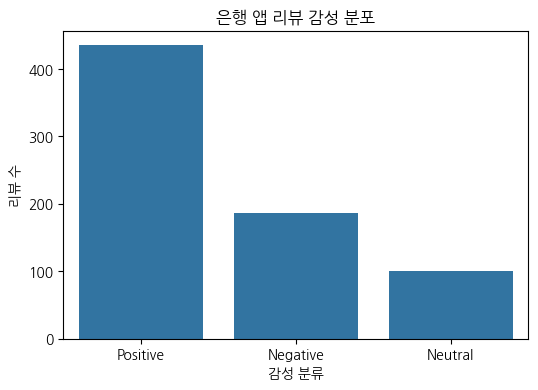

In [40]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.figure(figsize=(6, 4))
sns.countplot(data=bank_reviews, x='Sentiment', order=bank_reviews['Sentiment'].value_counts().index)
plt.title("은행 앱 리뷰 감성 분포")
plt.xlabel("감성 분류")
plt.ylabel("리뷰 수")
plt.show()

Step 5: 토픽 모델링 (LDA)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_counts = vectorizer.fit_transform(bank_reviews_df['cleaned'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_counts)

def show_topics(model, feature_names, n_words):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        print(f"🔹 Topic {idx+1}: {', '.join(top_words)}")

show_topics(lda, vectorizer.get_feature_names_out(), 10)

🔹 Topic 1: pay, card, googl, work, phone, use, payment, time, tri, support
🔹 Topic 2: card, balanc, gift, updat, work, time, app, account, tri, pleas
🔹 Topic 3: bank, money, app, save, account, great, use, updat, love, time


In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\campus4D019\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\campus4D019\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\campus4D019\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


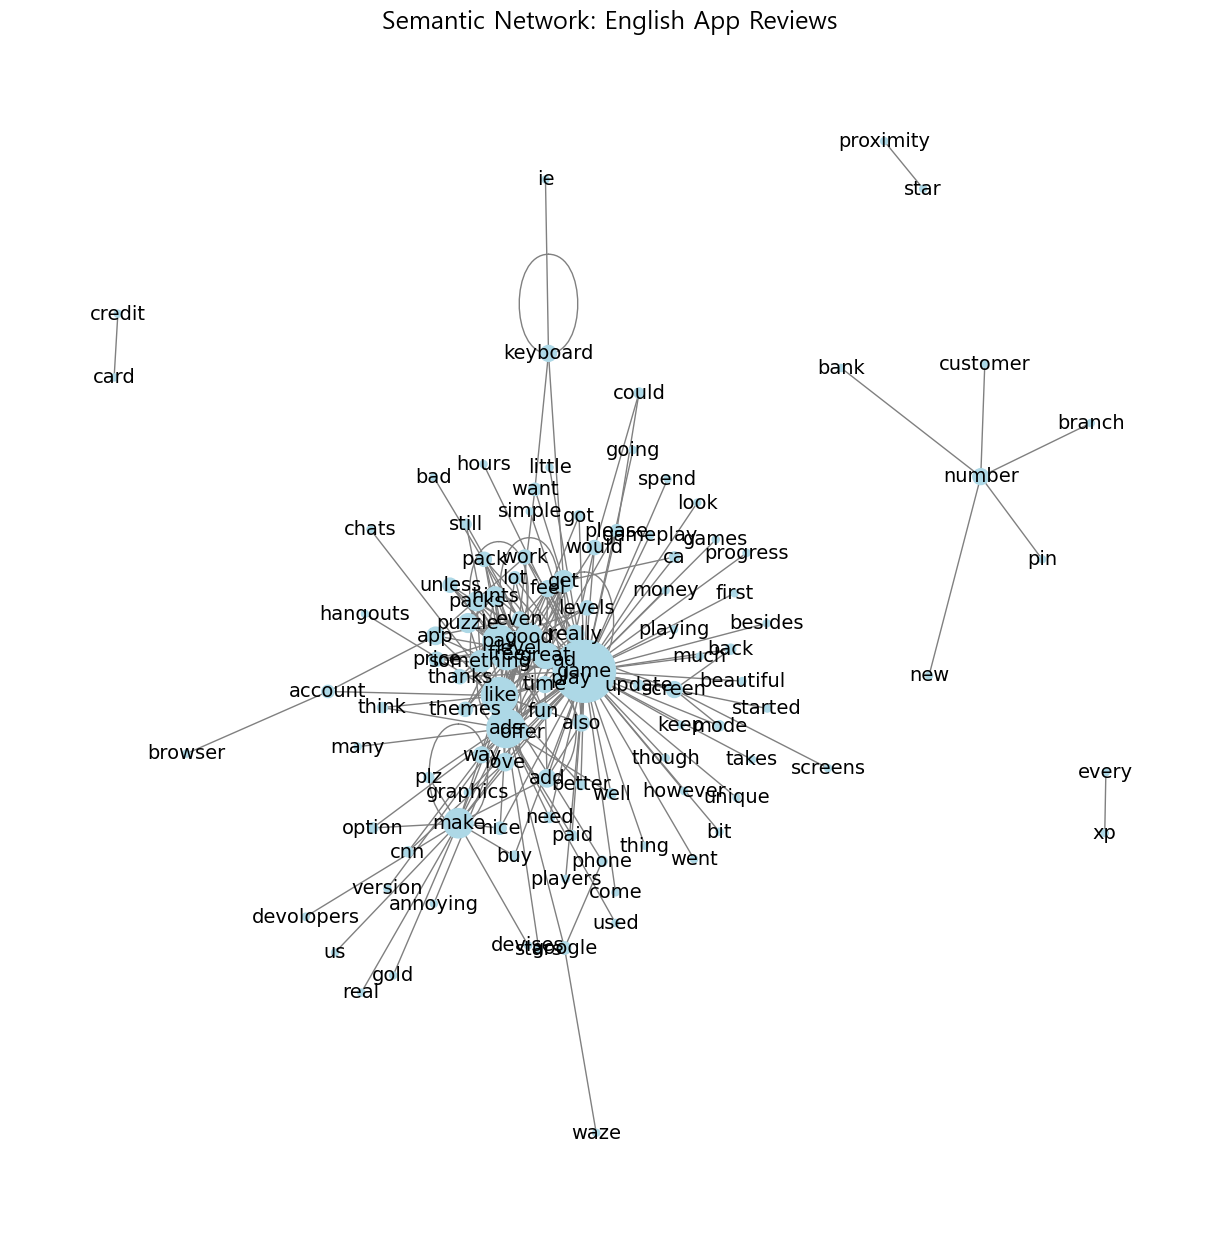

In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 다운로드 필요 시
nltk.download('punkt')
nltk.download('stopwords')

# 데이터 불러오기
reviews_df = pd.read_csv("Data/googleplaystore_user_reviews.csv")
sample_reviews = reviews_df['Translated_Review'].dropna().sample(300, random_state=42)

# 불용어 설정
stop_words = set(stopwords.words('english'))

# 문장별 단어 리스트
sentences_tokens = []
for review in sample_reviews:
    tokens = word_tokenize(review.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    if len(tokens) >= 2:
        sentences_tokens.append(tokens)

# 단어쌍 생성
word_pairs = []
for s in sentences_tokens:
    for pair in combinations(s, 2):
        word_pairs.append(tuple(sorted(pair)))

# 단어쌍 빈도 계산
word_pair_counts = Counter(word_pairs)

# 그래프 생성
G = nx.Graph()
for pair, freq in word_pair_counts.items():
    if freq >= 8:
        G.add_edge(pair[0], pair[1], weight=freq)

# 시각화
plt.figure(figsize=(12, 12))
if G.number_of_edges() > 0:
    pos = nx.spring_layout(G, k=0.5)
    dgr = nx.degree_centrality(G)
    node_size = [v * 3000 for v in dgr.values()]

    nx.draw(G, pos=pos, with_labels=True, node_size=node_size,
            node_color='lightblue', edge_color='gray', font_size=14)
    plt.title("Semantic Network: English App Reviews", fontsize=18)
    plt.show()
else:
    print("⚠️ 유의미한 단어쌍이 없어 그래프 생성 불가")


In [ ]:
# 중심성 상위 30개 단어만 추출해 서브그래프 만들기
centrality = nx.degree_centrality(G)
top_words = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:30]
top_nodes = [node for node, _ in top_words]
G_sub = G.subgraph(top_nodes)

# 시각화
pos = nx.spring_layout(G_sub, k=0.5)
nx.draw(G_sub, pos, with_labels=True, node_size=2000,
        node_color='skyblue', edge_color='gray', font_size=12)
plt.title("Top 30 Semantic Network from App Reviews")
plt.show()